In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Считаем данные

In [2]:
df = pd.read_excel('/home/oleg/labs/RG-FactorAnalysis/raw_data/EuqityMOEXReturns.xlsx', sheet_name='D')
df = df.drop(columns=df.columns[df.isna().sum() > len(df) / 2])
df = df.dropna()
df = df.rename(columns={'Unnamed: 0': 'date'})
df['date'] = df['date'].dt.date
df = df.sort_values(by='date').reset_index()
df.shape

(899, 69)

### Посмотрим на примеры данных

In [3]:
df_stocks = df.drop(df.columns[:2], axis=1)

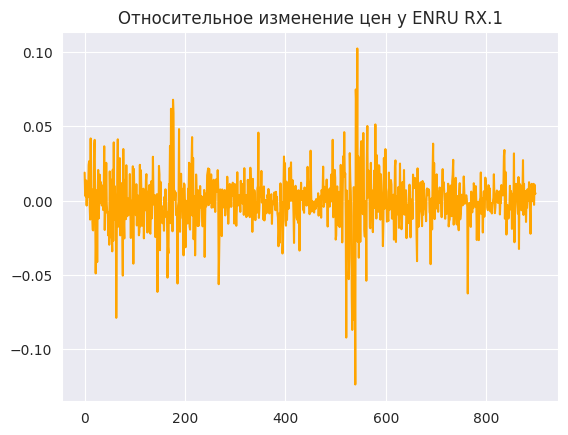

In [4]:
stock = np.random.choice(df_stocks.columns)
plt.plot(df[stock], color='orange')
plt.title(f"Относительное изменение цен у {stock}")
plt.show()

Виден тренд, но если пытаться прогнозировать более точно, то выходят несколько тоскливые настроения

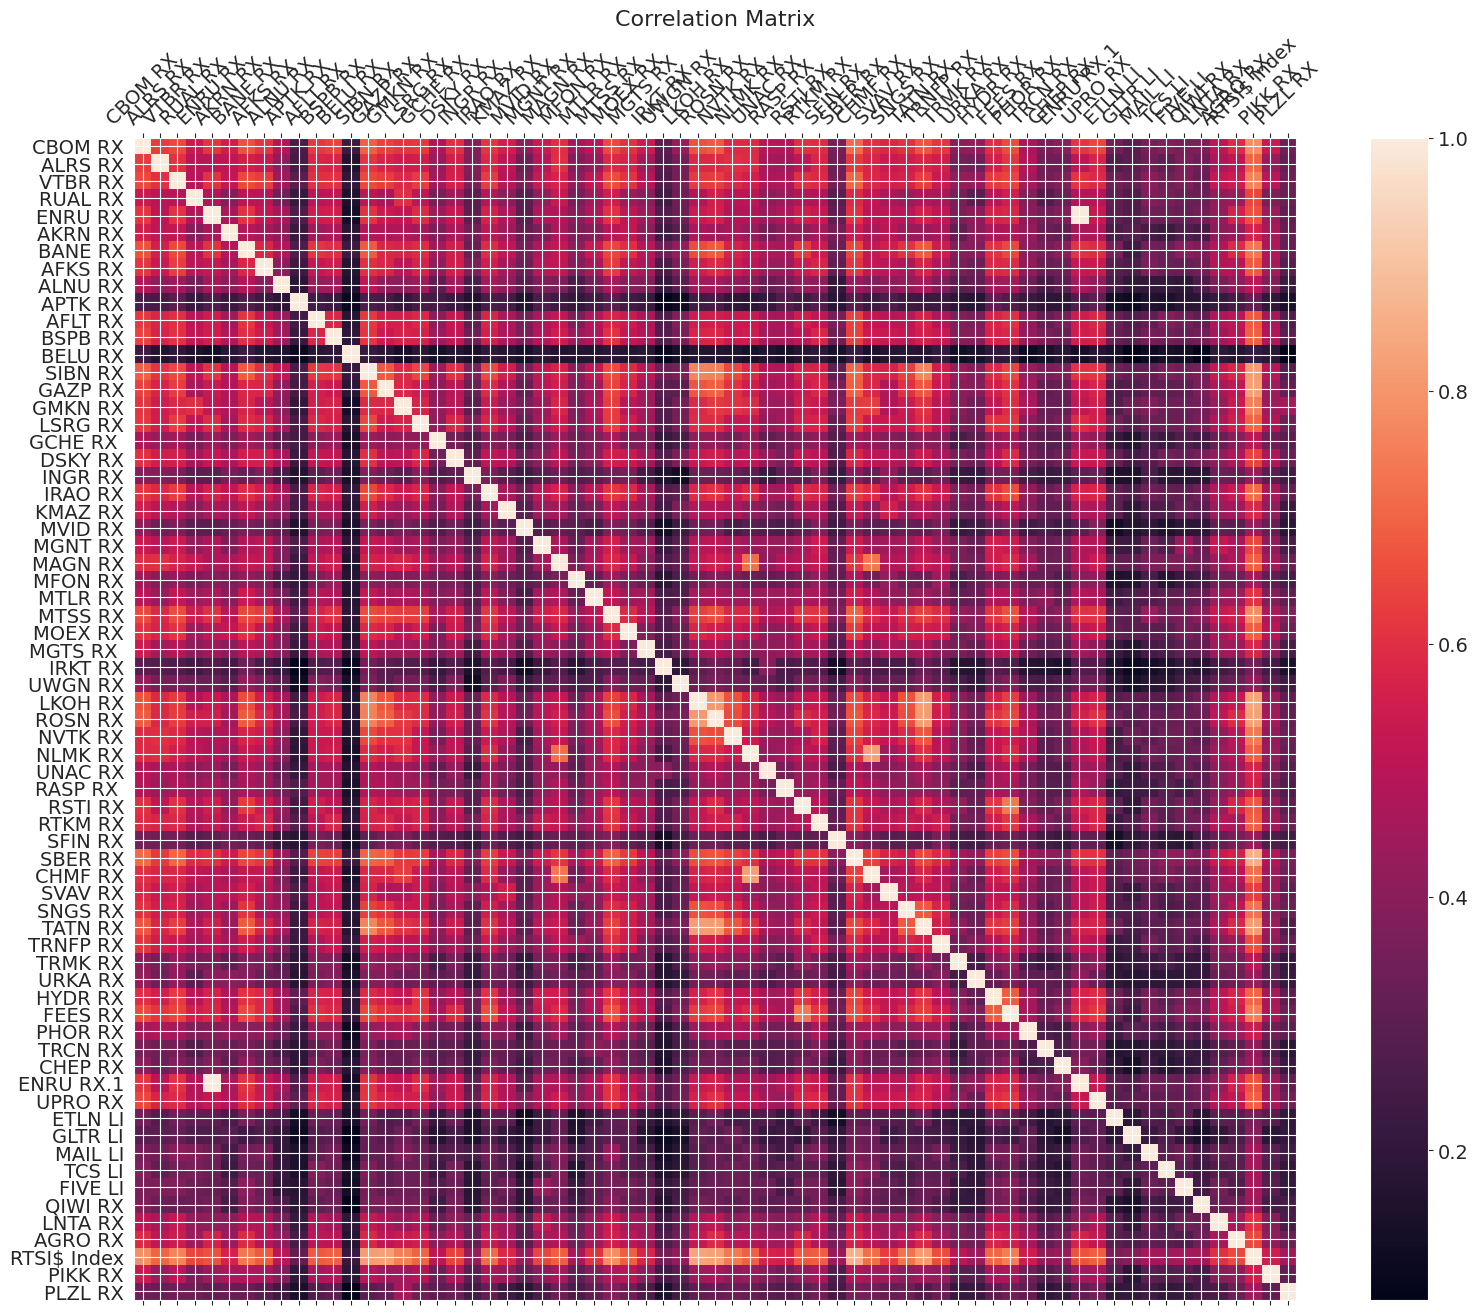

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_stocks.corr(), fignum=f.number)
plt.xticks(range(df_stocks.select_dtypes(['number']).shape[1]), df_stocks.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_stocks.select_dtypes(['number']).shape[1]), df_stocks.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [6]:
U, D, VT = np.linalg.svd(df_stocks.corr().to_numpy())

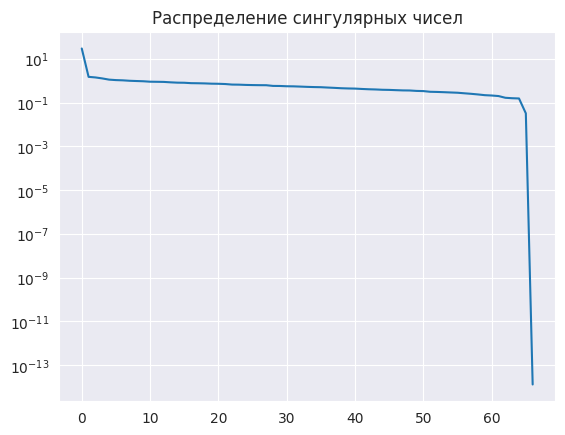

In [7]:
plt.plot(D)
plt.yscale("log")
plt.title("Распределение сингулярных чисел")
plt.show()

Видно, что первое сингулярное число очень сильн отличается от всех остальных. Это и есть наш тренд

In [8]:
D[0] = 0 # Собственно, обнулим

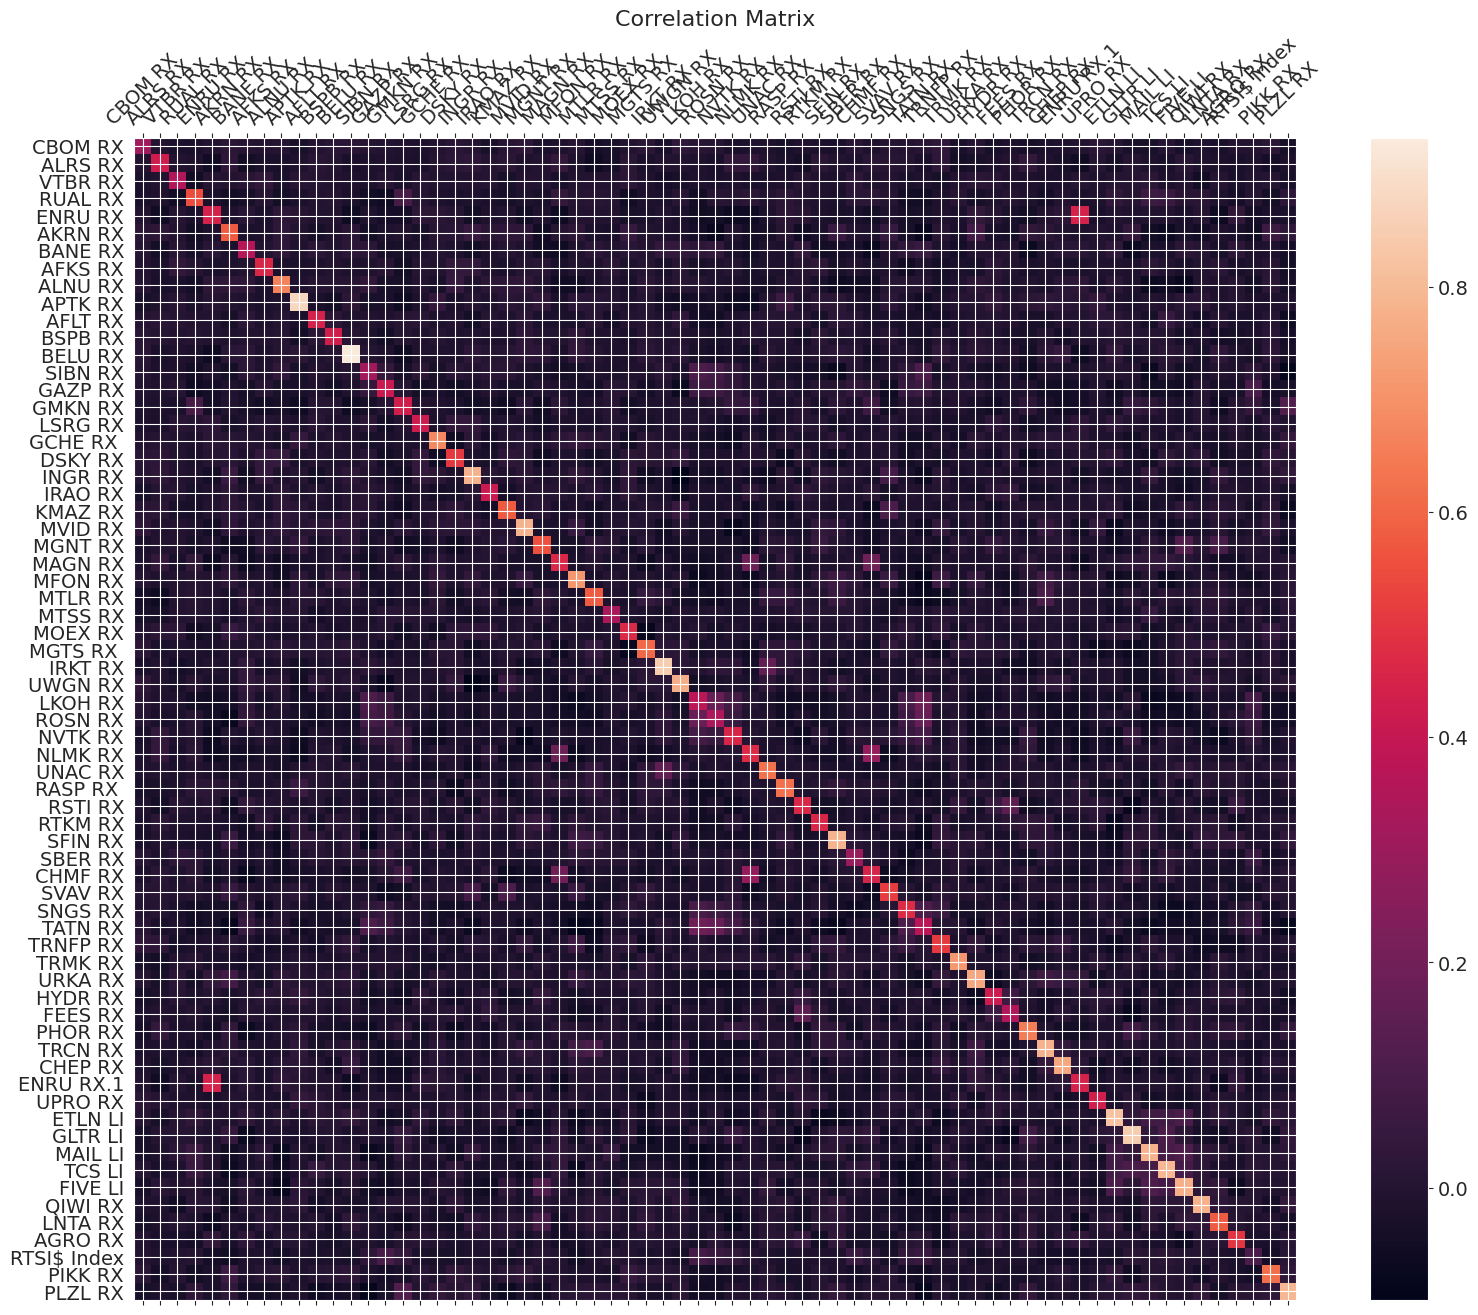

In [9]:
filter_correlation = U @ np.diag(D) @ VT
f = plt.figure(figsize=(19, 15))
plt.matshow(filter_correlation, fignum=f.number)
plt.xticks(range(df_stocks.select_dtypes(['number']).shape[1]), df_stocks.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_stocks.select_dtypes(['number']).shape[1]), df_stocks.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Ну вот, теперь почти никакой корреляции между элементами нет. Обидно, ну да ладно.

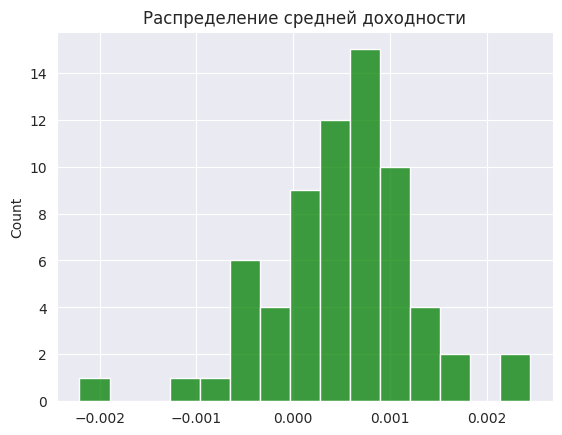

In [10]:
sns.histplot(df_stocks.mean(), bins=15, color='green')
plt.title("Распределение средней доходности")
plt.show()

### Теперь, собственно, применим DFM

In [11]:
import statsmodels.tsa.api as sm

In [12]:
train_stocks = df_stocks[:650]
test_stocks = df_stocks[650:]

In [13]:
test_stocks.shape

(249, 67)

In [39]:
model = sm.DynamicFactorMQ(endog=train_stocks, factors=6, factor_orders=2,
                           idiosyncratic_ar1=True)

In [40]:
results = model.fit(maxiter=100, disp=True)

EM start iterations, llf=-46490
EM iteration 2, llf=-44504, convergence criterion=0.043634
EM iteration 3, llf=-44226, convergence criterion=0.0062739
EM iteration 4, llf=-43989, convergence criterion=0.0053725
EM iteration 5, llf=-43759, convergence criterion=0.005238
EM iteration 6, llf=-43532, convergence criterion=0.005213
EM iteration 7, llf=-43305, convergence criterion=0.005216
EM iteration 8, llf=-43079, convergence criterion=0.0052298
EM iteration 9, llf=-42854, convergence criterion=0.0052494
EM iteration 10, llf=-42628, convergence criterion=0.0052725
EM iteration 11, llf=-42403, convergence criterion=0.0052978
EM iteration 12, llf=-42178, convergence criterion=0.0053243
EM iteration 13, llf=-41953, convergence criterion=0.0053518
EM iteration 14, llf=-41728, convergence criterion=0.0053799
EM iteration 15, llf=-41503, convergence criterion=0.0054084
EM iteration 16, llf=-41278, convergence criterion=0.0054374
EM iteration 17, llf=-41053, convergence criterion=0.0054668
EM i

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2648: UserWarning: Log-likelihood decreased at EM iteration 45. Reverting to the results from EM iteration 44 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


EM terminated at iteration 44, llf=-35035, convergence criterion=0.006762 (while specified tolerance was 1e-06)


In [41]:
pred_stocks = results.predict(start=650, end=650 + 249)

In [42]:
errors = pred_stocks - test_stocks

Text(0.5, 1.0, 'Средняя абсолютная ошибка в зависимости от дня наблюдений')

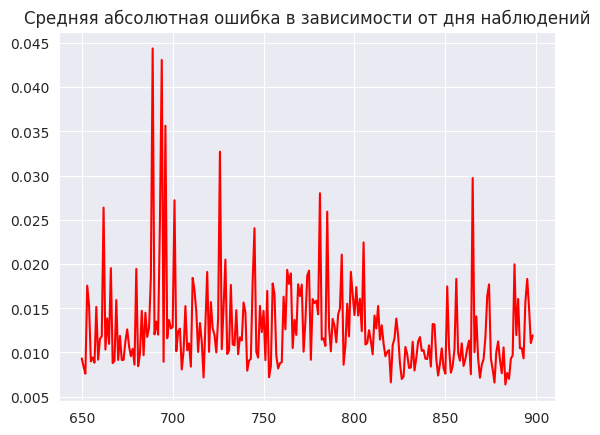

In [43]:
plt.plot(np.mean(np.abs(errors), axis=1), color='red')
plt.title("Средняя абсолютная ошибка в зависимости от дня наблюдений")

Text(0.5, 1.0, 'Средняя квадратическая ошибка')

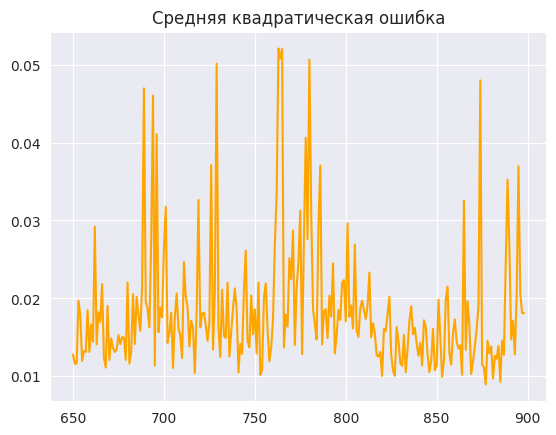

In [44]:
plt.plot((np.mean(errors**2, axis=1))**0.5, color='orange')
plt.title("Средняя квадратическая ошибка")

In [45]:
print(f"L1-error is {np.mean(np.mean(np.abs(errors)))}")
print(f"L2-error is {np.mean(np.mean(np.abs(errors**2)))**0.5}")

L1-error is 0.012822365045179862
L2-error is 0.020094526126026878


In [46]:
mean_res = train_stocks.mean().to_numpy()

In [47]:
baseline = test_stocks - mean_res

In [48]:
print(f"L1-error is {np.mean(np.mean(np.abs(baseline)))}")
print(f"L2-error is {np.mean(np.mean(np.abs(baseline**2)))**0.5}")

L1-error is 0.01282375837302805
L2-error is 0.02009571611259861


Text(0.5, 1.0, 'Средняя абсолютная ошибка в зависимости от дня наблюдений')

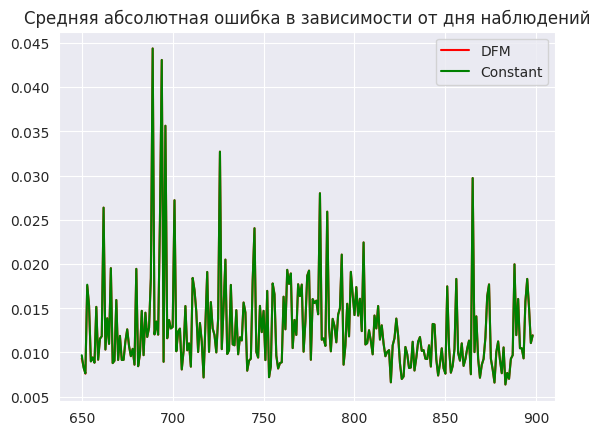

In [50]:
plt.plot(np.mean(np.abs(errors), axis=1), color='red')
plt.plot(np.mean(np.abs(baseline), axis=1), color='green')
plt.legend(["DFM", "Constant"])
plt.title("Средняя абсолютная ошибка в зависимости от дня наблюдений")

Как можно заметить, разницы почти нет с константным прогнозом.
Лучше не получилось. Но, в принципе, из матрицы корелляции выше что-то подобное и ожидалось